### 04 - Modelos ML (consumo y tiempos)

Objetivo: entrenar y comparar modelos clásicos multi-salida para predecir consumo de MP y tiempos.


#### Imports y carga de datos

In [39]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Dataset generado en el notebook 03 (ajusta la ruta si usas otra carpeta)
DATA_PATH = "../../data/proccessed/consumo/consumo_model_dataset.csv"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head(3)


Dataset shape: (30948, 250)


,peso_neto_kg,qty_plan,qty_estimado,throughput_uph,scrap_rate,downtime_min,piezas_ok,piezas_scrap,qty_in_almacen_dia,horas_teoricas,reduccion_tco,horas_ajustadas,horas_netas,ref_id_str_000305,ref_id_str_002260,ref_id_str_003501,ref_id_str_003800,ref_id_str_006700,ref_id_str_008011,ref_id_str_008091,ref_id_str_008203,ref_id_str_009400,ref_id_str_010002,ref_id_str_042421,ref_id_str_049390,ref_id_str_055105,ref_id_str_081000,ref_id_str_081002,ref_id_str_081302,ref_id_str_081303,ref_id_str_081505,ref_id_str_081602,ref_id_str_081803,ref_id_str_081901,ref_id_str_081902,ref_id_str_086503,ref_id_str_091700,ref_id_str_092901,ref_id_str_094900,ref_id_str_118302,ref_id_str_121105,ref_id_str_190301,ref_id_str_190900,ref_id_str_191000,ref_id_str_394205,ref_id_str_473205,ref_id_str_510086,ref_id_str_552012,ref_id_str_563404,ref_id_str_613839,ref_id_str_704388,ref_id_str_704389,ref_id_str_818500,ref_id_str_902081,ref_id_str_904802,ref_id_str_911100,ref_id_str_913600,ref_id_str_918801,ref_id_str_936105,ref_id_str_936205,...,machine_name_Talladora49,machine_name_Talladora52,machine_name_Talladora56,machine_name_Talladora83,machine_name_Temple154,machine_name_Temple19,machine_name_Temple191,machine_name_Temple303,machine_name_Torno Coroa 305,machine_name_Torno Daewo V15,machine_name_Torno152,machine_name_Torno153,machine_name_Torno165,machine_name_Torno198,machine_name_Torno199,machine_name_Torno201,machine_name_Torno54,machine_name_Torno63,machine_name_Torno88,machine_name_nan,op_id_APLANADO,op_id_CALIBRADO,op_id_CALIBRADO EX,op_id_CALIBRAR FRI,op_id_CURVADO-CORT,op_id_CURVAR-CORTA,op_id_ENTRADA DE D,op_id_FRESADO,op_id_FRESADO EXTE,op_id_GRANALLADO,op_id_GRANALLADO E,op_id_GRANALLAR,op_id_NORMALIZADO,op_id_NORMALIZAR,op_id_RECTIFICADO,op_id_REFRENTAR UN,op_id_SACAR ENTRAD,op_id_SOLDADURA-RE,op_id_SOLDAR-REBAB,op_id_TALLADO,op_id_TALLAR,op_id_TEMPLAR POR,op_id_TEMPLE-REVEN,op_id_TORNEADO,op_id_TORNEAR REBA,op_id_TORNEAR Ø EX,op_id_nan,año_mes_2025-01,año_mes_2025-02,año_mes_2025-03,año_mes_2025-04,año_mes_2025-05,año_mes_2025-06,año_mes_2025-07,año_mes_2025-08,año_mes_2025-09,año_mes_nan,consumo_materia_kg_target,kg_scrap_target,horas_fabricacion_target
0,5.0,0.0,592.0,0.000000,NaN,0.0,0,0,NaN,12350.0,788.0,11562.0,10420.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,0.0,0.816667
1,5.0,0.0,592.0,0.000000,NaN,32.0,0,0,NaN,12350.0,788.0,11562.0,10420.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.0,0.0,0.533333
2,5.0,0.0,592.0,21.724138,0.027778,0.0,105,3,NaN,12350.0,788.0,11562.0,10420.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,F

In [40]:

# Asumimos que los targets creados en el notebook 03 están presentes
targets = [c for c in df.columns if c.endswith('_target')]
X = df.drop(columns=targets)
Y = df[targets]

print("Features:", X.shape, "Targets:", Y.shape)

# Imputar NaN con 0 (una opción simple dado que ya son dummies y numéricos)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
Y_imp = Y.copy()  # as targets no NaNs expected; si hubiera, se podrían imputar aparte

X_train, X_temp, y_train, y_temp = train_test_split(X_imp, Y_imp, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print({"train": len(X_train), "val": len(X_val), "test": len(X_test)})


Features: (30948, 247) Targets: (30948, 3)
{'train': 21663, 'val': 4642, 'test': 4643}


#### Helpers de métricas

In [41]:

def eval_model(model, X, y_true, label=""):
    y_pred = model.predict(X)
    metrics = {}
    for i, col in enumerate(y_true.columns):
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i]) ** 0.5
        metrics[col] = {"MAE": mae, "RMSE": rmse}
    df_metrics = pd.DataFrame(metrics).T
    df_metrics.insert(0, "split", label)
    return df_metrics


#### Modelos a probar

In [42]:

# Grid de hiperparámetros por modelo
param_grid = {
    "ridge": [
        {"alpha": 0.1},
        {"alpha": 1.0},
        {"alpha": 10.0},
    ],
    "random_forest": [
        {"n_estimators": 200, "max_depth": None},
        {"n_estimators": 200, "max_depth": 10},
        {"n_estimators": 400, "max_depth": 20},
    ],
    "gbr": [
        {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 3},
        {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 4},
        {"n_estimators": 300, "learning_rate": 0.1, "max_depth": 3},
    ],
}

base_models = {
    "ridge": Ridge,
    "random_forest": RandomForestRegressor,
    "gbr": GradientBoostingRegressor,
}

val_results = []
best_models = {}

for name, cls in base_models.items():
    best_score = np.inf
    best_entry = None
    for params in param_grid[name]:
        model_instance = cls(**params)
        # Soporte multi-salida
        model = MultiOutputRegressor(model_instance)
        model.fit(X_train, y_train)
        res = eval_model(model, X_val, y_val, label=f"val_{name}")
        res.insert(0, "modelo", name)
        res.insert(1, "params", str(params))
        val_results.append(res)
        # Selección por suma de RMSE
        total_rmse = res["RMSE"].sum()
        if total_rmse < best_score:
            best_score = total_rmse
            best_entry = {"model": model, "params": params, "metrics": res}
    best_models[name] = best_entry

val_metrics_table = pd.concat(val_results)
print("Resultados validación (por target):")
print(val_metrics_table)

Resultados validación (por target):
                                  modelo                                             params              split           MAE          RMSE
consumo_materia_kg_target          ridge                                     {'alpha': 0.1}          val_ridge  6.745649e+02  1.910504e+03
kg_scrap_target                    ridge                                     {'alpha': 0.1}          val_ridge  3.283695e-14  2.025320e-13
horas_fabricacion_target           ridge                                     {'alpha': 0.1}          val_ridge  1.731930e+00  2.473369e+00
consumo_materia_kg_target          ridge                                     {'alpha': 1.0}          val_ridge  6.750378e+02  1.908998e+03
kg_scrap_target                    ridge                                     {'alpha': 1.0}          val_ridge  3.281754e-14  2.025447e-13
horas_fabricacion_target           ridge                                     {'alpha': 1.0}          val_ridge  1.731587e+00  2.47

#### Selección de mejor modelo (por suma de RMSE)

In [43]:

# Métricas en test para cada mejor modelo
test_results = []
for name, entry in best_models.items():
    model = entry["model"]
    # Re-entrenar en train+val con los mejores hiperparámetros
    model.fit(pd.concat([X_train, X_val], ignore_index=True), pd.concat([y_train, y_val], ignore_index=True))
    test_res = eval_model(model, X_test, y_test, label=f"test_{name}")
    test_res.insert(0, "modelo", name)
    test_res.insert(1, "params", str(entry["params"]))
    test_results.append(test_res)

metrics_table_test = pd.concat(test_results)
print("Resultados test (por target):")
print(metrics_table_test)

# Selección de mejor modelo global por suma de RMSE en test
metrics_table_test["RMSE"] = metrics_table_test["RMSE"].astype(float)
global_best = (metrics_table_test.reset_index()
                .groupby("modelo")["RMSE"].sum()
                .sort_values())
best_model_name = global_best.index[0]
best_model = best_models[best_model_name]["model"]
print("Mejor modelo global (RMSE sum test):", best_model_name)


Resultados test (por target):
                                  modelo                                             params               split           MAE          RMSE
consumo_materia_kg_target          ridge                                    {'alpha': 10.0}          test_ridge  6.600175e+02  1.712551e+03
kg_scrap_target                    ridge                                    {'alpha': 10.0}          test_ridge  2.933787e-14  1.760494e-13
horas_fabricacion_target           ridge                                    {'alpha': 10.0}          test_ridge  1.657970e+00  2.330264e+00
consumo_materia_kg_target  random_forest             {'n_estimators': 400, 'max_depth': 20}  test_random_forest  1.484255e+01  2.751538e+02
kg_scrap_target            random_forest             {'n_estimators': 400, 'max_depth': 20}  test_random_forest  1.557449e-14  1.789657e-13
horas_fabricacion_target   random_forest             {'n_estimators': 400, 'max_depth': 20}  test_random_forest  9.265671e-02  4.0

#### Gráficos y vs y_pred (MP y horas)

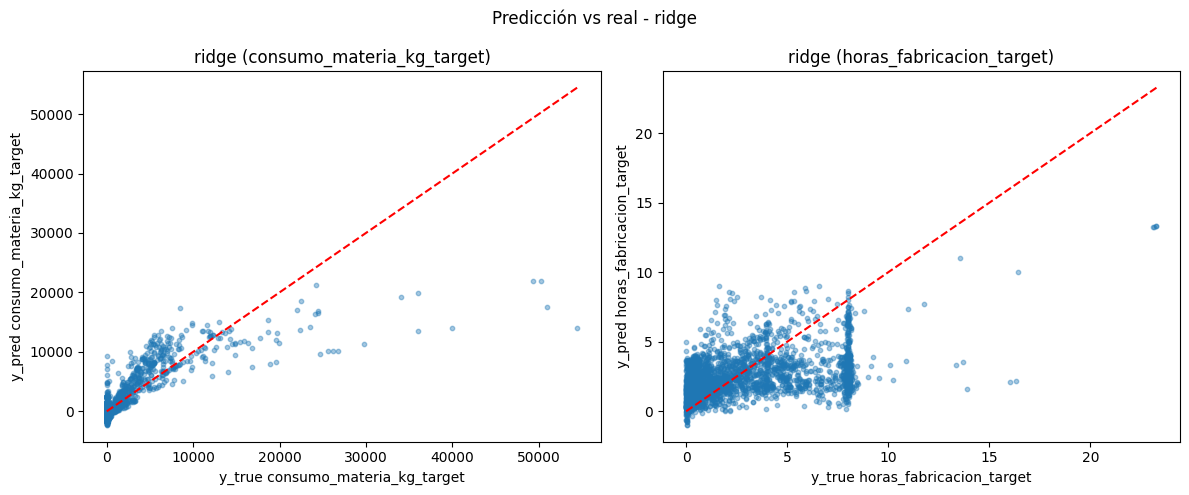

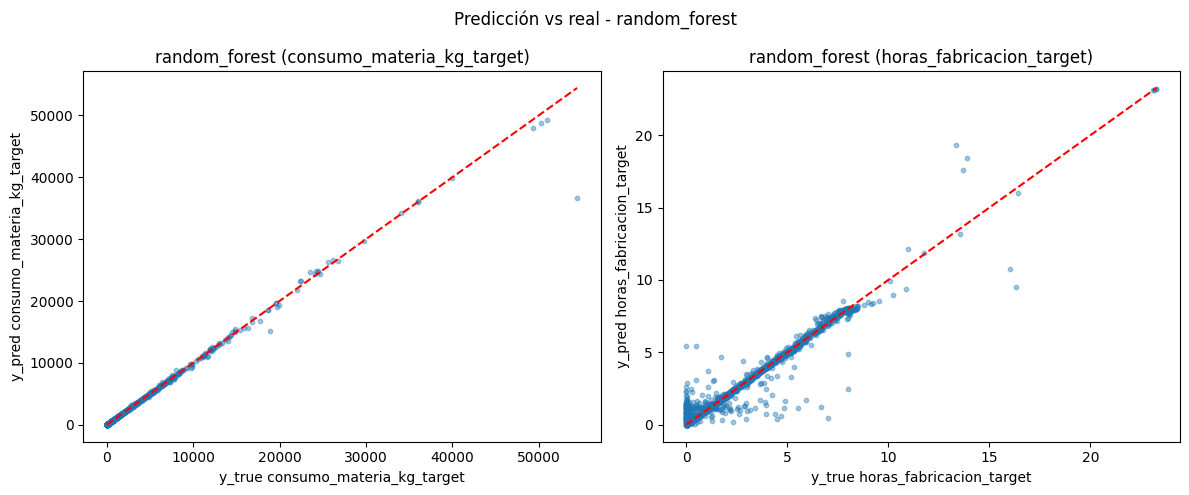

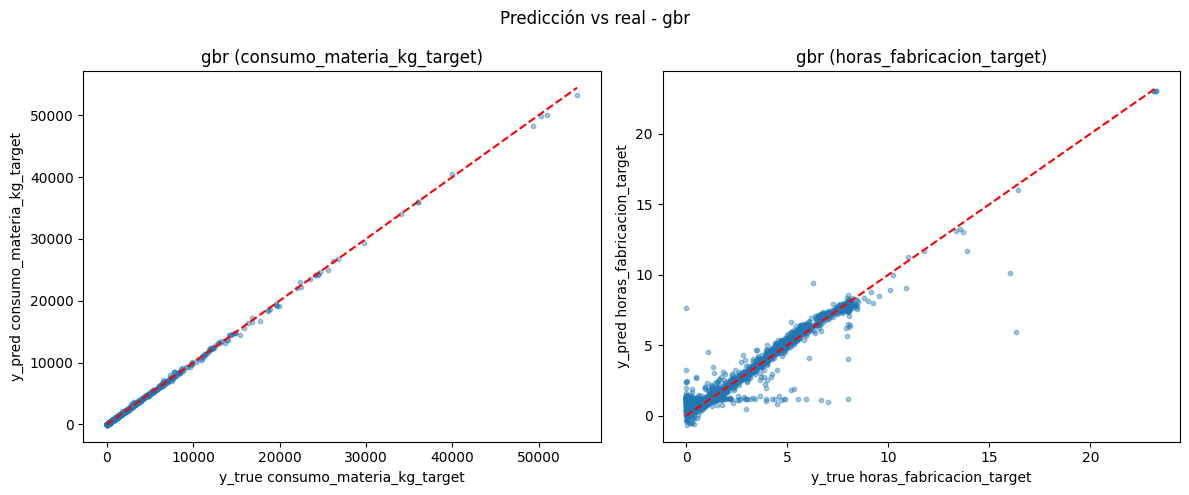

In [44]:

cols_plot = [c for c in ['consumo_materia_kg_target','horas_fabricacion_target'] if c in y_test.columns]
for name, entry in best_models.items():
    model = entry["model"]
    y_pred = model.predict(X_test)
    fig, axes = plt.subplots(1, len(cols_plot), figsize=(6*len(cols_plot), 5))
    if len(cols_plot) == 1:
        axes = [axes]
    for ax, col in zip(axes, cols_plot):
        idx = list(y_test.columns).index(col)
        y_true_col = y_test[col]
        y_pred_col = y_pred[:, idx]
        ax.scatter(y_true_col, y_pred_col, alpha=0.4, s=10)
        ax.plot([y_true_col.min(), y_true_col.max()], [y_true_col.min(), y_true_col.max()], 'r--')
        ax.set_xlabel(f"y_true {col}")
        ax.set_ylabel(f"y_pred {col}")
        ax.set_title(f"{name} ({col})")
    plt.suptitle(f"Predicción vs real - {name}")
    plt.tight_layout()
    plt.show()


#### Referencias conocidas por el modelo

In [49]:

# Listado de referencias presentes en el dataset (dummies ref_id_str_*)
ref_cols = [c for c in X.columns if c.startswith('ref_id_str_')]
refs_conocidas = [c.replace('ref_id_str_','') for c in ref_cols]
print(f"Refs conocidas ({len(refs_conocidas)}):")
print(sorted(refs_conocidas))


Refs conocidas (49):
['000305', '002260', '003501', '003800', '006700', '008011', '008091', '008203', '009400', '010002', '042421', '049390', '055105', '081000', '081002', '081302', '081303', '081505', '081602', '081803', '081901', '081902', '086503', '091700', '092901', '094900', '118302', '121105', '190301', '190900', '191000', '394205', '473205', '510086', '552012', '563404', '613839', '704388', '704389', '818500', '902081', '904802', '911100', '913600', '918801', '936105', '936205', '936305', 'nan']


#### Importancias de características (si el modelo las soporta)

ridge no expone feature_importances_.
Importancias - random_forest
piezas_ok                     0.566157
peso_neto_kg                  0.425167
familia_ARO                   0.002025
ref_id_str_613839             0.001975
familia_CORONA DE ARRANQUE    0.001071
ref_id_str_081000             0.000874
qty_estimado                  0.000727
throughput_uph                0.000544
ref_id_str_190301             0.000257
ref_id_str_936305             0.000161
reduccion_tco                 0.000147
horas_ajustadas               0.000129
año_mes_2025-01               0.000109
piezas_scrap                  0.000085
scrap_rate                    0.000082
horas_teoricas                0.000048
ref_id_str_510086             0.000029
horas_netas                   0.000029
op_id_CURVADO-CORT            0.000028
qty_in_almacen_dia            0.000026
dtype: float64


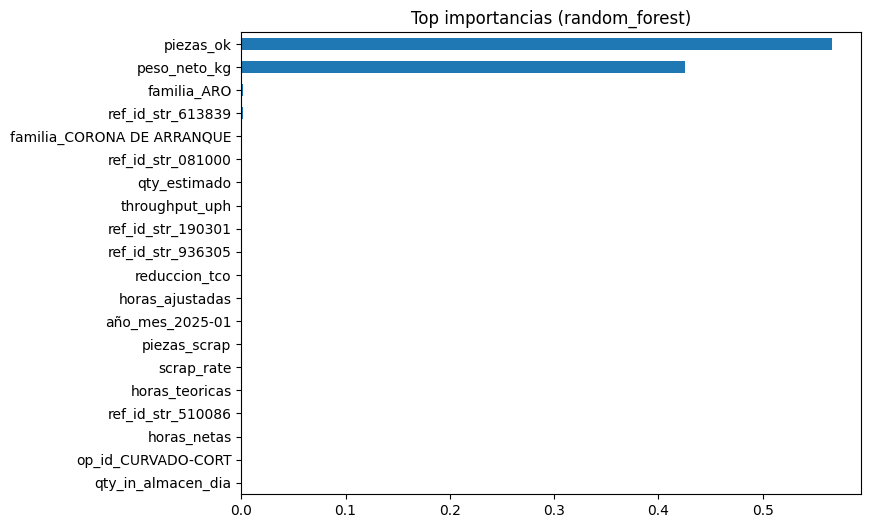

Importancias - gbr
piezas_ok                     0.554520
peso_neto_kg                  0.439420
familia_CORONA DE ARRANQUE    0.002011
familia_ARO                   0.001670
ref_id_str_613839             0.001187
qty_estimado                  0.000563
throughput_uph                0.000317
horas_teoricas                0.000073
machine_id_25                 0.000070
machine_id_118                0.000029
ref_id_str_000305             0.000015
qty_in_almacen_dia            0.000014
ref_id_str_510086             0.000013
scrap_rate                    0.000013
piezas_scrap                  0.000012
op_id_GRANALLADO E            0.000009
ref_id_str_704388             0.000006
ref_id_str_936305             0.000006
ref_id_str_473205             0.000005
machine_name_Horno            0.000004
dtype: float64


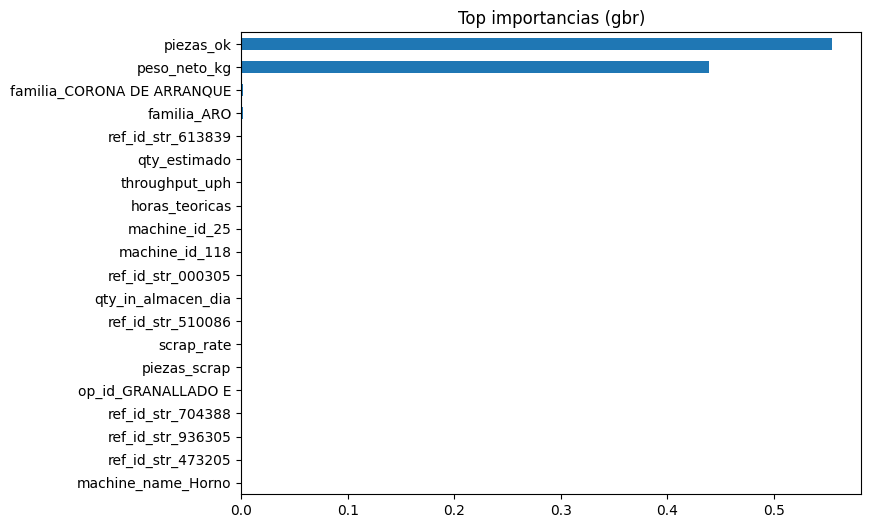

In [45]:

for name, entry in best_models.items():
    model = entry["model"]
    # Si es MultiOutput, el estimador base expone importancias
    base_estimator = model.estimators_[0] if hasattr(model, 'estimators_') else model
    if hasattr(base_estimator, 'feature_importances_'):
        importances = pd.Series(base_estimator.feature_importances_, index=X.columns)
        top_imp = importances.sort_values(ascending=False).head(20)
        print(f"Importancias - {name}")
        print(top_imp)
        top_imp.plot(kind='barh', figsize=(8,6), title=f'Top importancias ({name})')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"{name} no expone feature_importances_.")


#### ***Ejemplo de prueba***

In [57]:
ref = "081000"   # o "081302.0" según dummies
qty_objetivo = 10000

# Encontrar la columna dummy exacta
ref_cols = [c for c in X.columns if c.startswith("ref_id_str_")]
hit = [c for c in ref_cols if c.endswith(ref)]
if not hit:
    raise ValueError(f"La ref {ref} no existe en el dataset de entrenamiento.")
ref_col = hit[0]

# Fila base: mediana de la ref; si no hay filas (shouldn’t happen), usa medianas globales
mask_ref = X[ref_col] == 1
if mask_ref.any():
    base = X[mask_ref].median(numeric_only=True)
else:
    base = X.median(numeric_only=True)

row = base.copy()

# Cantidades objetivo
for col in ["qty_plan", "qty_estimado"]:
    if col in row:
        row[col] = float(qty_objetivo)

# Asegurar que el dummy de ref está a 1 y el resto de dummies de ref a 0
for c in ref_cols:
    row[c] = 1.0 if c == ref_col else 0.0

# Convertir a DataFrame y predecir
row_df = pd.DataFrame([row])
row_imp = pd.DataFrame(imputer.transform(row_df), columns=X.columns)
y_pred = best_model.predict(row_imp)[0]
pred = pd.Series(y_pred, index=y_train.columns)

print(f"Predicción para ref {ref} y {qty_objetivo} piezas:")
print(pred.round(2).to_string())

Predicción para ref 081000 y 10000 piezas:
consumo_materia_kg_target    0.25
kg_scrap_target              0.00
horas_fabricacion_target     0.10


#### Guardar modelo

In [47]:

models_dir = Path("../../models/ml-consumo")
models_dir.mkdir(parents=True, exist_ok=True)

val_metrics_table.to_csv(models_dir / "metrics_val.csv", index=False)
metrics_table_test.to_csv(models_dir / "metrics_test.csv")
best_summary = pd.DataFrame([
    {"modelo": name, "params": str(entry["params"])} for name, entry in best_models.items()
])
best_summary.to_csv(models_dir / "best_models.csv", index=False)
print("Métricas guardadas en models/ (val y test) y best_models.csv")


Métricas guardadas en models/ (val y test) y best_models.csv
